Purpose of this notebook:

1. Enable quick manual segmentation of large TIF images containing multiple tiles in x-y and multiple z-planes, in a single channel
2. Create a table of cells X ROIs also containing information about the location of the cell in vivo (within a particular FOV)
3. Allow each cell to have ROIs in multiple z planes
4. Work with single image stitched in x-y if possible
5. Use ROIs from one channel to calculate intensity in other channels and produce histogram

Make sure notebook is opened in py365 environment

# Setup

In [1]:
%gui qt5 

In [1]:
# Imports in alphabetical order of module name

from IPython.display import display
from PIL import Image, ImageDraw
import napari
import numpy as np
import pickle as pkl
import matplotlib.path as mpltpath
import matplotlib.pyplot as plt


# Load images

## Segmentation channel

In [2]:
## Specify images to load

# folder2 = 'Z:\HCR\9.2_FISH\S1_dapi_546_488_647'
folder = 'F:\HCR\HCR_10.17\sampleA_dapi_vip_sst_ndnf_pv_vgat_TW'

# base_filename2 = 'S1_dapi_546_488_647_s2z'
base_filename = 'sampleA_dapi_vip_sst_ndnf_pv_vgat_TW_'

plane_nos = range(1)
n = len(plane_nos)
print('Number of planes: {0}'.format(n))

Number of planes: 1


In [3]:
# Create 4D array to store images
img = Image.open('{0}\{1}c6_ORG_bg_sub.tif'.format(folder, base_filename))
# img2 = Image.open('{0}\{1}{2}c1+2+3+4.tif'.format(folder2, base_filename2, str(plane_nos[0]).zfill(2)))

h = img.height
# h2 = img2.height                  
                  
w = img.width
# w2 = img2.width
                  
# c = np.array(img).shape[2]
im_array = np.zeros([n, h, w])
# im_array2 = np.zeros([n, h2, w2])
print('Size of image in pixels: {0} X {1} X {2}'.format(n, h, w))

for i in range(n):
    print('Loading image {0}'.format(i + 1))
    p = plane_nos[i]
    img = Image.open('{0}\{1}c6_ORG.tif'.format(folder, base_filename))
#     img2 = Image.open('{0}\{1}{2}c1+2+3+4.tif'.format(folder2, base_filename2, str(p).zfill(2)))
    try:
        im_array[i, :, :] = np.array(img)
#         im_array2[i, :, :] = np.array(img2)[:, :, 0]
    except:
        print('Plane {0} could not be loaded'.format(p))
        print('Size of plane {0} in pixels: {0} X {1}'.format(img.height, img.width))
        im_array = np.delete(im_array, i, axis = 0)
        plane_nos.remove(p)
        i -= 1
        n = len(plane_nos)

        continue


C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\PIL\Image.py:2735: DecompressionBombWarning: Image size (95609284 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Size of image in pixels: 1 X 9778 X 9778
Loading image 1


## Load other channels

In [4]:
#Background subtracted
print('Ndnf')
im_array_ndnf = np.zeros([n, h, w])
img_file = 'sampleA_dapi_vip_sst_ndnf_pv_vgat_TW_c4_ORG_bg_sub'
img = Image.open('{0}\{1}.tif'.format(folder, img_file))
im_array_ndnf[i, :, :] = np.array(img)

print('Vip')
im_array_vip = np.zeros([n, h, w])
img_file = 'sampleA_dapi_vip_sst_ndnf_pv_vgat_TW_c2_ORG_bg_sub'
img = Image.open('{0}\{1}.tif'.format(folder, img_file))
im_array_vip[i, :, :] = np.array(img)

print('Sst')
im_array_sst = np.zeros([n, h, w])
img_file = 'sampleA_dapi_vip_sst_ndnf_pv_vgat_TW_c3_ORG_bg_sub'
img = Image.open('{0}\{1}.tif'.format(folder, img_file))
im_array_sst[i, :, :] = np.array(img)
        

Ndnf
Vip
Sst


# Annotation

## Data structure to store information about cells

In [5]:
class Cell:
    n_cells = 1
    cell_data = {}
    
    def __init__(self, cell_no):
        
        self.cell_no = cell_no
        self.z_planes = []
        self.no_planes = 0
        self.masks = {}
        self.c_vals = np.zeros(1)
        print('Cell #{0} created'.format(Cell.n_cells))
        
    def add_mask(self, z_plane, mask):
        self.z_planes.append(z_plane)
        self.no_planes += 1
        self.masks[z_plane] = mask
            
    def save_cell(self):
        Cell.cell_data[self.cell_no] = {'cell_id': self.cell_no,
                                 'z_planes': self.z_planes,
                                 'masks': self.masks,
                                 'no_planes': self.no_planes,
                                 'c_vals':self.c_vals}

In [27]:
# Load masks if they already exist
save_loc = 'F:\HCR\HCR_10.17'
save_file= 'TW_data.pkl'
try:
    with open('{0}\{1}'.format(save_loc, save_file), 'rb') as f:
        Cell.cell_data = pkl.load(f)
        indices = list(Cell.cell_data.keys())
        if not np.max(indices) == len(indices):
            print('Re-numbering cells to be consecutive')
            Cell.cell_data_temp = {}
            for i in range(len(indices)):
                Cell.cell_data_temp[i + 1] = Cell.cell_data[indices[i]]
                Cell.cell_data_temp[i + 1]['cell_id'] = i + 1
            Cell.cell_data = Cell.cell_data_temp 
            with open('{0}\{1}'.format(save_loc, save_file), 'wb') as f:
                pkl.dump(Cell.cell_data, f)
            Cell.n_cells = i + 1
        else:
            Cell.n_cells = len(indices)
    print('{0} cells found'.format(Cell.n_cells))
except:
    print('No data found')

51 cells found


## Render image in napari GUI

In [9]:
# Open image in napari viewer - each channel as a separate layer 
viewer = napari.Viewer()

viewer.add_image(im_array[:, :, :], name = 'Channel {0}'.format(i + 1), colormap = 'viridis', 
                     interpolation = 'nearest')
    
seg_channel = 0
viewer.add_shapes([], name = 'masks', opacity = 0.2, face_color = 'white', edge_color = 'red', edge_width = 3)

# Add existing masks
indices = list(Cell.cell_data.keys())
mask_layer = viewer.layers['masks']
for cell in indices:
    plane = Cell.cell_data[cell]['z_planes'][0]
    mask = Cell.cell_data[cell]['masks'][plane]
    mask_layer.add(mask, shape_type = 'polygon', opacity = 0.2, face_color = 'white', edge_color = 'red', edge_width = 3)

# Keybinding functions

@viewer.bind_key('n')
def new_cell(viewer):
    global cell1 
    Cell.n_cells += 1
    cell1 = Cell(Cell.n_cells)

@viewer.bind_key('m')
def add_mask(viewer):
    seg_layer = viewer.layers[seg_channel]
    z_plane = seg_layer.coordinates[0]
    mask = viewer.layers['masks'].data[-1]
    cell1.add_mask(z_plane, mask)
    
@viewer.bind_key('k')
def save_cell(viewer):
    cell1.save_cell()
    
@viewer.bind_key('Control-s')
def save_all(viewer):
    with open('{0}\{1}'.format(save_loc, save_file), 'wb') as f:
                pkl.dump(Cell.cell_data, f)

C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\vispy\visuals\markers.py:564: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('a_edgewidth', np.float32, 1)])


<Shapes layer 'masks' at 0x22bd240>

In [21]:
with open('{0}\{1}'.format(save_loc, save_file), 'wb') as f:
                pkl.dump(Cell.cell_data, f)

## Manual segmentation

In [21]:
Cell.n_cells

1

In [85]:
if Cell.n_cells > 1:
    cell1.save_cell()
    print('Cell {0} saved'.format(cell1.cell_no))
cell1 = Cell(Cell.n_cells)

Cell 21 saved
Cell #22 created


In [87]:
seg_layer = viewer.layers[seg_channel]
z_plane = seg_layer.coordinates[0]


mask = viewer.layers['masks'].data[-1]
cell1.add_mask(z_plane, mask)
print('mask {0} added in z-plane {1} for cell {2}'.format(cell1.no_planes, z_plane, cell1.cell_no))

mask 2 added in z-plane 11 for cell 22


In [88]:
with open('{0}\{1}'.format(save_loc, save_file), 'wb') as f:
    pkl.dump(cell_data, f)

## Calculate intensity in other channels

In [7]:
try:
    with open('F:/HCR/HCR_10.17/TW_mask_vertices.pkl'.format(folder), 'rb') as f:
        mask_vertices = pkl.load(f)
        print('Data loaded')
        
except IOError:
    print('No saved data found, calculating mask pixels')
    xv = range(w)
    yv = range(h)
    coord_array = np.array(np.meshgrid(xv, yv))

    points = np.zeros([h*w, 2])
    p = 0
    for i in range(h):
        for j in range(w):
            points[p, 1] = coord_array[0, i, j]
            points[p, 0] = coord_array[1, i, j]
            p += 1

    no_cells = len(Cell.cell_data.keys())
    mask_vertices = {}
    for cell in range(no_cells):
        if np.mod(cell, 10) == 0:
            print('Cell {0}'.format(cell))
        cell_no = cell + 1
        mask_vertices[cell_no] = {}
        cell_dict = Cell.cell_data[cell_no]
        masks = cell_dict['masks']
        z_planes = cell_dict['z_planes']
        for plane in z_planes:

            vertices = masks[plane]
            path = mpltpath.Path(vertices)
            mask = path.contains_points(points)
            mask = np.reshape(mask, [h, w])
            mask_vertices[cell_no][plane] = np.where(mask)

    with open('F:/HCR/HCR_10.17/TW_mask_vertices.pkl'.format(folder), 'wb') as f:
        pkl.dump(mask_vertices, f)

Data loaded


In [8]:
no_cells = len(Cell.cell_data.keys())
avg_intensity_ndnf = np.zeros(no_cells)
avg_intensity_vip = np.zeros(no_cells)
avg_intensity_sst = np.zeros(no_cells)

for cell in range(no_cells):
    
    if np.mod(cell, 10) == 0:
        print('Cell {0}'.format(cell))
    cell_no = cell + 1
    cell_dict = Cell.cell_data[cell_no]
    z_planes = cell_dict['z_planes']

    intensity_ndnf = np.zeros(cell_dict['no_planes'])
    intensity_vip = np.zeros(cell_dict['no_planes'])
    intensity_sst = np.zeros(cell_dict['no_planes'])
    
    i = 0
    for plane in z_planes:

        xy_coord = mask_vertices[cell_no][plane]
        x = xy_coord[0]
        y = xy_coord[1]
        intensity_ndnf[i] = np.mean(im_array_ndnf[plane - 1, x, y])
        intensity_vip[i] = np.mean(im_array_vip[plane - 1, x, y])
        intensity_sst[i] = np.mean(im_array_sst[plane - 1, x, y])
        i += 1
    
    avg_intensity_ndnf[cell] = np.mean(intensity_ndnf)
    avg_intensity_vip[cell] = np.mean(intensity_vip)
    avg_intensity_sst[cell] = np.mean(intensity_sst)

    with open('F:/HCR/HCR_10.17/TW_data_ndnf_sst_vip.pkl', 'wb') as f:
        pkl.dump({'Ndnf': avg_intensity_ndnf, 'Sst': avg_intensity_sst, 'Vip':avg_intensity_vip}, f)

Cell 0
Cell 10
Cell 20
Cell 30
Cell 40
Cell 50


In [9]:
z_planes

[1]

In [73]:
plt.figure()
gene1_level = avg_intensity_ndnf
gene2_level = avg_intensity_vip

plt.scatter(gene1_level/np.max(gene1_level), gene2_level/np.max(gene2_level), 
            color = 'k', marker = 'o',
           alpha = 0.2)


plt.xlabel('Relative expression of Ndnf')
plt.ylabel('Relative expression of Vip')

t1 = 0.3
t2 = 0.2

n_cells = Cell.n_cells
plt.plot(np.ones(2)*t1, np.array(range(0, 2)), '--', color = 'r')
plt.plot(np.array(range(0, 2)), np.ones(2)*t2, '--',  color = 'r')

q1 = np.sum(np.logical_and(gene1_level/np.max(gene1_level) < t1, 
                    gene2_level/np.max(gene2_level) < t2))
plt.text(0, 0, '{0} %'.format(np.round(q1/n_cells*100, decimals = 0)), fontsize = 12)

q2 = np.sum(np.logical_and(gene1_level/np.max(gene1_level) < t1, 
                    gene2_level/np.max(gene2_level) > t2))
plt.text(0, 1, '{0} %'.format(np.round(q2/n_cells*100, decimals = 0)), fontsize = 12)

q3 = np.sum(np.logical_and(gene1_level/np.max(gene1_level) > t1, 
                    gene2_level/np.max(gene2_level) < t2))
plt.text(0.8, 0, '{0} %'.format(np.round(q3/n_cells*100, decimals = 0)), fontsize = 12)

q4 = np.sum(np.logical_and(gene1_level/np.max(gene1_level) > t1, 
                    gene2_level/np.max(gene2_level) > t2))
plt.text(0.8, 1, '{0} %'.format(np.round(q4/n_cells*100, decimals = 0)), fontsize = 12)

Text(0.8, 1, '0.0 %')

# Check saved masks

## Check number of masks per cell, and variance of mask centers

In [56]:
indices = list(Cell.cell_data.keys())
n_planes = np.zeros(len(indices)).astype(int)
var_masks = np.zeros([len(indices), 2])

if not np.max(indices) == len(indices):
    print('Re-numbering cells to be consecutive')
    Cell.cell_data_temp = {}
    for i in range(len(indices)):
        Cell.cell_data_temp[i + 1] = Cell.cell_data[indices[i]]
        Cell.cell_data_temp[i + 1]['cell_id'] = i + 1
    Cell.cell_data = Cell.cell_data_temp 
    with open('{0}\{1}'.format(save_loc, save_file), 'wb') as f:
        pkl.dump(Cell.cell_data, f)
        
for i in range(len(indices)):
    z_planes = Cell.cell_data[i + 1]['z_planes']
    n_planes[i] = len(z_planes)
    masks = Cell.cell_data[i + 1]['masks']
    centers = np.zeros([n_planes[i], 2])
    for j in range(n_planes[i]):
        centers[j, 0] = np.mean(masks[z_planes[j]][:, 0])
        centers[j, 1] = np.mean(masks[z_planes[j]][:, 1])
    var_masks[i, 0] = np.var(centers[:, 0])
    var_masks[i, 1] = np.var(centers[:, 1])
    
    

Re-numbering cells to be consecutive


In [58]:
fig, ax = plt.subplots(nrows = 2, ncols = 1, sharex = True, figsize = [15, 5])
ax[0].plot(n_planes)
ax[0].set_xlabel('Cell number')
ax[0].set_ylabel('Number of masks')
ax[1].plot(var_masks[:, 0], label = 'y_values')
ax[1].plot(var_masks[:, 1], label = 'x_values')
ax[1].set_ylabel('Variance of centers')
ax[1].plot(range(len(indices)), np.ones(len(indices))*8, '--', color = 'k')
ax[1].legend()

In [44]:
ind = np.nonzero(var_masks > 500)[0]

In [45]:
ind

array([52, 52], dtype=int64)

In [50]:
cell_no = 3
masks = Cell.cell_data[cell_no]['masks']
masks

{1: array([[1220.55614825,  605.30761193],
        [1215.02955603,  611.75530285],
        [1221.47724695,  616.82134572],
        [1230.22768463,  616.82134572],
        [1241.28086906,  615.90024701],
        [1250.49185609,  619.58464183],
        [1255.55789896,  619.58464183],
        [1262.00558988,  619.58464183],
        [1269.83492885,  610.83420415],
        [1267.99273145,  604.84706258],
        [1262.92668858,  601.62321712],
        [1256.47899766,  600.24156907],
        [1251.4129548 ,  599.78101971],
        [1244.04416517,  597.47827296],
        [1233.45153009,  595.1755262 ],
        [1227.92493787,  594.71497685],
        [1225.62219112,  596.0966249 ]]),
 2: array([[1216.87175344,  596.0966249 ],
        [1216.87175344,  605.76816128],
        [1222.39834566,  614.05804961],
        [1231.14878333,  617.74244442],
        [1239.89922101,  619.12409247],
        [1249.57075739,  619.12409247],
        [1258.78174442,  619.12409247],
        [1265.68998469,  614.979

In [55]:
Cell.cell_data.pop(cell_no)

{'cell_id': 3,
 'z_planes': [1, 2, 3, 0],
 'masks': {1: array([[1220.55614825,  605.30761193],
         [1215.02955603,  611.75530285],
         [1221.47724695,  616.82134572],
         [1230.22768463,  616.82134572],
         [1241.28086906,  615.90024701],
         [1250.49185609,  619.58464183],
         [1255.55789896,  619.58464183],
         [1262.00558988,  619.58464183],
         [1269.83492885,  610.83420415],
         [1267.99273145,  604.84706258],
         [1262.92668858,  601.62321712],
         [1256.47899766,  600.24156907],
         [1251.4129548 ,  599.78101971],
         [1244.04416517,  597.47827296],
         [1233.45153009,  595.1755262 ],
         [1227.92493787,  594.71497685],
         [1225.62219112,  596.0966249 ]]),
  2: array([[1216.87175344,  596.0966249 ],
         [1216.87175344,  605.76816128],
         [1222.39834566,  614.05804961],
         [1231.14878333,  617.74244442],
         [1239.89922101,  619.12409247],
         [1249.57075739,  619.12409247]

## Check that number of masks is correctly stored

In [63]:
# Load masks if they already exist
save_loc = 'F:\HCR\HCR_10.17'
save_file= 'S3_data.pkl'
try:
    with open('{0}\{1}'.format(save_loc, save_file), 'rb') as f:
        Cell.cell_data = pkl.load(f)
        indices = list(Cell.cell_data.keys())
        no_masks_stored = np.zeros(len(indices))
        no_planes = np.zeros(len(indices))
        no_z_planes_stored = np.zeros(len(indices))
        if not np.max(indices) == len(indices):
            print('Re-numbering cells to be consecutive')
            Cell.cell_data_temp = {}
            for i in range(len(indices)):
                Cell.cell_data_temp[i + 1] = Cell.cell_data[indices[i]]
                Cell.cell_data_temp[i + 1]['cell_id'] = i + 1
                no_masks_stored[i] = len(Cell.cell_data[indices[i]]['masks'].keys())
                no_z_planes_stored[i] = len(Cell.cell_data[indices[i]]['z_planes'])
                no_planes[i] = Cell.cell_data[indices[i]]['no_planes']
            Cell.cell_data = Cell.cell_data_temp 
            with open('{0}\{1}'.format(save_loc, save_file), 'wb') as f:
                pkl.dump(Cell.cell_data, f)
            Cell.n_cells = i + 1
        else:
            Cell.n_cells = len(indices)
            for cell in range(len(indices)):
                no_masks_stored[cell] = len(Cell.cell_data[cell + 1]['masks'].keys())
                no_z_planes_stored[cell] = len(Cell.cell_data[cell + 1]['z_planes'])
                no_planes[cell] = Cell.cell_data[cell + 1]['no_planes']
    print('{0} cells found'.format(Cell.n_cells))
except:
    print('No data found')
    
plt.figure()
plt.plot(no_masks_stored, label = 'Number of masks stored')
plt.plot(no_planes, label = 'Number of planes')
plt.plot(no_z_planes_stored, label = 'Number of z_planes stored')
plt.legend()

201 cells found


## View saved masks in new napari window

In [326]:
# Open image in napari viewer - each channel as a separate layer 
viewer2 = napari.Viewer()

viewer2.add_image(im_array2[:, :, :], name = 'Channel {0}'.format(i + 1), colormap = 'viridis', 
                     interpolation = 'nearest')
    
indices = list(Cell.cell_data.keys())
viewer2.add_shapes(mask, shape_type = 'polygon', opacity = 0.2, face_color = 'white', edge_color = 'red', edge_width = 3)
mask_layer = viewer2.layers['Shapes']
for cell in indices:
    plane = Cell.cell_data[cell]['z_planes'][0]
    mask = Cell.cell_data[cell]['masks'][plane]
    mask_layer.add(mask, shape_type = 'polygon', opacity = 0.2, face_color = 'white', edge_color = 'red', edge_width = 3)


C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\vispy\visuals\markers.py:564: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('a_edgewidth', np.float32, 1)])
C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\vispy\visuals\markers.py:564: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('a_edgewidth', np.float32, 1)])
C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\vispy\visuals\markers.py:564: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  ('a_edgewidth', np.float32, 1)])
C:\Users\singha\AppData\Local\Continuum\anaconda3\envs\py365\lib\site-packages\vis

In [303]:
mask_layer.add()

{1: {'cell_id': 1,
  'z_planes': [1],
  'masks': {1: array([[1203.88111044,  337.39930311],
          [1200.28185564,  338.59905471],
          [1197.08251804,  342.39826811],
          [1195.68280784,  345.19768851],
          [1199.28206264,  347.79715031],
          [1203.08127604,  349.59677772],
          [1206.88048944,  350.39661212],
          [1209.47995124,  348.99690192],
          [1211.47953724,  346.59739871],
          [1211.27957864,  342.99814391],
          [1208.48015824,  339.19893051],
          [1207.68032384,  338.19913751]])},
  'no_planes': 1,
  'c_vals': array([0.])},
 2: {'cell_id': 2,
  'z_planes': [1, 2],
  'masks': {1: array([[1211.33317027,  392.72244235],
          [1208.9794914 ,  393.21279212],
          [1208.48914163,  394.87998132],
          [1208.88142144,  398.41049963],
          [1209.96019093,  401.64680808],
          [1211.72545008,  403.41206723],
          [1214.17719891,  404.39276676],
          [1216.92315759,  405.47153624],
          

# Find cortex surface and calculate depths

In [11]:
with open('F:/HCR/HCR_10.17/TW_depths.pkl', 'rb') as f:
    depths = pkl.load(f)

In [40]:
# Find centroid of each cell mask
centers = np.zeros([Cell.n_cells, 2])
med_planes = np.zeros(Cell.n_cells)

for cell in range(Cell.n_cells):
    
    cell_id = cell + 1
    planes = Cell.cell_data[cell_id]['z_planes']
    med_planes[cell] = int(np.median(planes))
    
    mask = Cell.cell_data[cell_id]['masks'][med_planes[cell]]
    centers[cell, :] = np.mean(mask, 0).astype(int)

In [41]:
def find_depth(d1, d2, cell_center): #d1 and d2 are two points on the surface closest to the cell center
    
    dx = d2[0] - d1[0]
    dy = d2[1] - d1[1]
    d1_cell_x = cell_center[0] - d1[0]
    d1_cell_y = cell_center[1] - d1[1]
    t = (dx * d1_cell_x + dy * d1_cell_y) / (dx * dx + dy * dy)
    px = d1[0] + t * dx # Projection of cell center onto line joining d1 and d2
    py = d1[1] + t * dy
    depth = np.linalg.norm([px - cell_center[0], py - cell_center[1]])
    return depth


In [42]:
um_per_px = 0.21

(array([2., 0., 5., 4., 5., 3., 1., 2., 3., 6., 6., 1., 3., 1., 1., 4., 0.,
        0., 0., 4.]),
 array([  3.8681638 ,  14.53406706,  25.19997033,  35.8658736 ,
         46.53177687,  57.19768014,  67.86358341,  78.52948667,
         89.19538994,  99.86129321, 110.52719648, 121.19309975,
        131.85900301, 142.52490628, 153.19080955, 163.85671282,
        174.52261609, 185.18851936, 195.85442262, 206.52032589,
        217.18622916]),
 <a list of 20 Patch objects>)

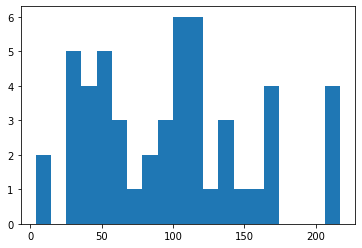

In [44]:
# Draw surface and calculate depths
surface = viewer.layers['masks'].data[-1]
depths = np.zeros(Cell.n_cells)

for cell in range(Cell.n_cells):
    distances = np.linalg.norm(centers[cell, :] - surface, axis = 1)
    order = np.argsort(distances)
    [p1, p2] = order[0:2]
    d1 = surface[p1]
    d2 = surface[p2]
    depths[cell] = find_depth(d1, d2, centers[cell, :])
depths = depths*um_per_px
with open('F:/HCR/HCR_10.17/TW_depths.pkl', 'wb') as f:
    pkl.dump(depths, f)
plt.figure()
plt.hist(depths, 20)

In [35]:
max_depth = 120
all_cells = np.array(range(Cell.n_cells))
cell_ids = all_cells[depths < max_depth]

avg_intensity_shallow_ndnf = avg_intensity_ndnf[cell_ids]
avg_intensity_shallow_vip = avg_intensity_vip[cell_ids]
avg_intensity_shallow_sst = avg_intensity_sst[cell_ids]

In [36]:
plt.figure()
gene1_level = avg_intensity_shallow_ndnf
gene2_level = avg_intensity_shallow_vip
gene1_level_all = avg_intensity_ndnf
gene2_level_all = avg_intensity_vip

plt.scatter(gene1_level/np.max(gene1_level_all), gene2_level/np.max(gene2_level_all), 
            color = 'k', marker = 'o',
           alpha = 0.2)


plt.xlabel('Relative expression of Ndnf')
plt.ylabel('Relative expression of Vip')

t1 = 0.4
t2 = 0.2

n_cells = cell_ids.shape[0]
plt.plot(np.ones(2)*t1, np.array(range(0, 2)), '--', color = 'r')
plt.plot(np.array(range(0, 2)), np.ones(2)*t2, '--',  color = 'r')

q1 = np.sum(np.logical_and(gene1_level/np.max(gene1_level_all) < t1, 
                    gene2_level/np.max(gene2_level_all) < t2))
plt.text(0, 0, '{0} %'.format(np.round(q1/n_cells*100, decimals = 0)), fontsize = 12)

q2 = np.sum(np.logical_and(gene1_level/np.max(gene1_level_all) < t1, 
                    gene2_level/np.max(gene2_level_all) > t2))
plt.text(0, 1, '{0} %'.format(np.round(q2/n_cells*100, decimals = 0)), fontsize = 12)

q3 = np.sum(np.logical_and(gene1_level/np.max(gene1_level_all) > t1, 
                    gene2_level/np.max(gene2_level_all) < t2))
plt.text(0.8, 0, '{0} %'.format(np.round(q3/n_cells*100, decimals = 0)), fontsize = 12)

q4 = np.sum(np.logical_and(gene1_level/np.max(gene1_level_all) > t1, 
                    gene2_level/np.max(gene2_level_all) > t2))
plt.text(0.8, 1, '{0} %'.format(np.round(q4/n_cells*100, decimals = 0)), fontsize = 12)

Text(0.8, 1, '0.0 %')

In [31]:
%matplotlib qt

In [39]:
# Plot intensity vs depth for all channels
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 10))

ax[0].scatter(depths, avg_intensity_ndnf, color = 'k', alpha = 0.5)
ax[0].set_title('Ndnf intensity vs depth')

ax[1].scatter(depths, avg_intensity_vip, color = 'k', alpha = 0.5)
ax[1].set_title('Vip intensity vs depth')

ax[2].scatter(depths, avg_intensity_sst, color = 'k', alpha = 0.5)
ax[2].set_title('Sst intensity vs depth')

Text(0.5, 1.0, 'Sst intensity vs depth')

In [47]:
%matplotlib qt

Text(0.5, 1.0, 'Max intensity = 14373')

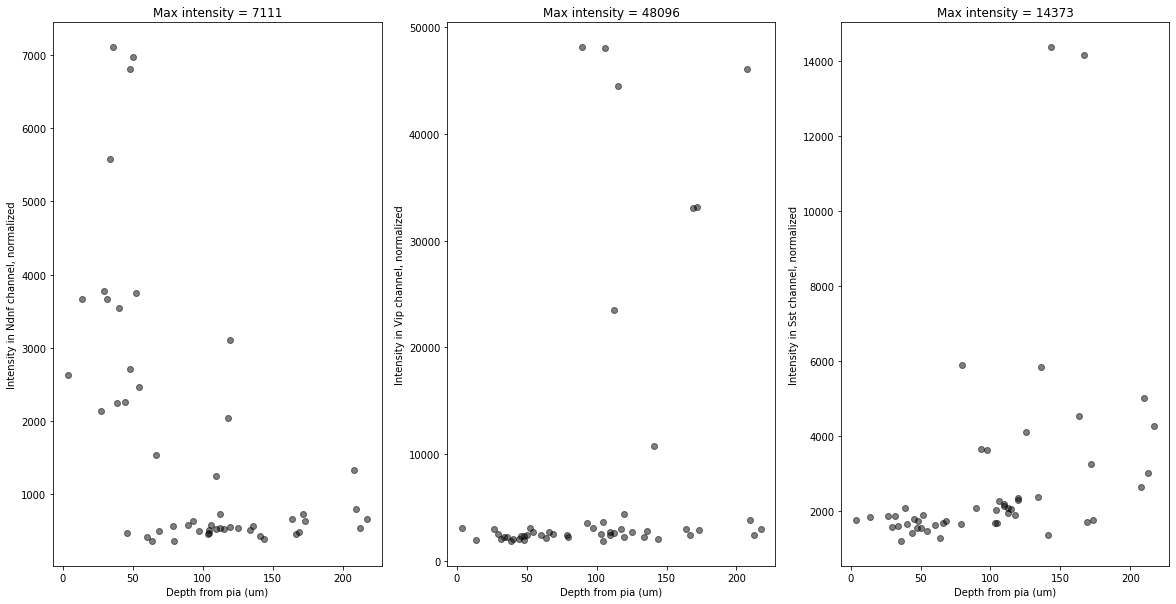

In [12]:
# Plot intensity vs depth for all channels
fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 10))

#ax[0].scatter(depths, avg_intensity_ndnf/np.max(avg_intensity_ndnf), color = 'k', alpha = 0.5)
ax[0].scatter(depths, avg_intensity_ndnf, color = 'k', alpha = 0.5)
ax[0].set_xlabel('Depth from pia (um)')
ax[0].set_ylabel('Intensity in Ndnf channel, normalized')
ax[0].set_title('Max intensity = {0}'.format(int(np.max(avg_intensity_ndnf))))

#ax[1].scatter(depths, avg_intensity_vip/np.max(avg_intensity_vip), color = 'k', alpha = 0.5)
ax[1].scatter(depths, avg_intensity_vip, color = 'k', alpha = 0.5)
ax[1].set_xlabel('Depth from pia (um)')
ax[1].set_ylabel('Intensity in Vip channel, normalized')
ax[1].set_title('Max intensity = {0}'.format(int(np.max(avg_intensity_vip))))

#ax[2].scatter(depths, avg_intensity_sst/np.max(avg_intensity_sst), color = 'k', alpha = 0.5)
ax[2].scatter(depths, avg_intensity_sst, color = 'k', alpha = 0.5)
ax[2].set_xlabel('Depth from pia (um)')
ax[2].set_ylabel('Intensity in Sst channel, normalized')
ax[2].set_title('Max intensity = {0}'.format(int(np.max(avg_intensity_sst))))

In [268]:
# After subtracting background

bg_sub_ndnf = avg_intensity_ndnf - avg_bg_ndnf
bg_sub_sst = avg_intensity_sst - avg_bg_sst
bg_sub_vip = avg_intensity_vip - avg_bg_vip

fig, ax = plt.subplots(nrows = 1, ncols = 3, figsize = (20, 10))

ax[0].scatter(depths, bg_sub_ndnf/np.max(bg_sub_ndnf), color = 'k', alpha = 0.5)
ax[0].set_xlabel('Depth from pia (um)')
ax[0].set_ylabel('Intensity in Ndnf channel, normalized')
ax[0].set_title('Max intensity = {0}'.format(int(np.max(bg_sub_ndnf))))

ax[1].scatter(depths, bg_sub_vip/np.max(bg_sub_vip), color = 'k', alpha = 0.5)
ax[1].set_xlabel('Depth from pia (um)')
ax[1].set_ylabel('Intensity in Vip channel, normalized')
ax[1].set_title('Max intensity = {0}'.format(int(np.max(bg_sub_vip))))

ax[2].scatter(depths, bg_sub_sst/np.max(bg_sub_sst), color = 'k', alpha = 0.5)
ax[2].set_xlabel('Depth from pia (um)')
ax[2].set_ylabel('Intensity in Sst channel, normalized')
ax[2].set_title('Max intensity = {0}'.format(int(np.max(bg_sub_sst))))

Text(0.5, 1.0, 'Max intensity = 6365')

# View raw images of each cell

In [24]:
%matplotlib qt

In [33]:
gene = 'sst'

if gene == 'sst':
    im_array = im_array_sst
    cell_order = np.argsort(avg_intensity_sst)
elif gene == 'vip':
    im_array = im_array_vip
    cell_order = np.argsort(avg_intensity_vip)
elif gene == 'ndnf':
    im_array = im_array_ndnf
    cell_order = np.argsort(avg_intensity_ndnf)
    
n_rows = 3
n_cols = 17
plt.style.use('dark_background')
fig, ax = plt.subplots(nrows = n_rows, ncols = n_cols, figsize = (30, 20))


size_um = 20 # In um
um_per_px = 0.21 # Size of a pixel in um
size_px = int(size_um/um_per_px/2)
mask_dil =  np.zeros([h, w]).astype(bool)

max_intensity = np.max(im_array)/5
min_intensity = np.min(im_array)

for cell in range(Cell.n_cells):
    
    row = int(cell/n_cols)
    col = np.mod(cell, n_cols)
    
    cell_id = cell_order[cell] + 1
    
    planes = Cell.cell_data[cell_id]['z_planes'] 
    med_plane = int(np.median(planes))
    
    mask = Cell.cell_data[cell_id]['masks'][med_plane]
    [x_center, y_center] = np.mean(mask, 0).astype(int)
    [x1, y1] = [np.max([0, x_center - size_px]), np.max([0, y_center - size_px])]
    [x2, y2] = [np.min([h, x_center + size_px]), np.min([w, y_center + size_px])]
    mask_dil[x1:x2, y1:y2] = np.ones([x2 - x1, y2 - y1])
    
    small_im = np.reshape(im_array[med_plane - 1, mask_dil], [np.min([x2 - x1, size_px*2]), np.min([y2 - y1, size_px*2])])
    ax[row, col].imshow(small_im, vmin = min_intensity, vmax = max_intensity)
    
    mask_dil[x1:x2, y1:y2] = np.zeros([x2 - x1, y2 - y1])
    
    ax[row, col].axis('off')
    if col == 0:
        ax[row, col].set_ylabel('{0}'.format(np.round(avg_inensity_sst[cell_id - 1], 2)))
        ax[row, col].axis('on')

# Local background correction

## Define background pixels

In [16]:
# All pixels not contained in any cell mask
bg_all = np.ones([n, h, w])
n_vert_all = {}
centers = {}

no_cells = len(Cell.cell_data.keys())
for cell in range(no_cells):
        
    cell_no = cell + 1
    cell_dict = Cell.cell_data[cell_no]
    z_planes = cell_dict['z_planes']
    n_vert_all[cell] = {}
    centers[cell] = {}
    
    for plane in z_planes:
        
        xy_coord = mask_vertices[cell_no][plane]
        x = xy_coord[0]
        y = xy_coord[1]
        z = plane - 1
        centers[cell][plane] = np.array([np.mean(x), np.mean(y)]).astype(int)
        
        
        bg_all[z, x, y] = np.zeros([1, len(x)])
        
        n_vert_all[cell][plane] = len(x) 

## Find local background of each cell

In [17]:
um_per_px = 0.21

In [21]:
# fig, ax = plt.subplots(nrows = 3, ncols = 20)
um_per_px = 0.21
no_cells = len(Cell.cell_data.keys())
avg_bg_ndnf = np.zeros(no_cells)
avg_bg_vip = np.zeros(no_cells)
avg_bg_sst = np.zeros(no_cells)

local_region = 50 # in um
local_px = int(local_region/um_per_px/2)

min_dist = 10 # in um
min_dist_px = min_dist/um_per_px

for cell in range(no_cells):
    cell_no = cell + 1
    cell_dict = Cell.cell_data[cell_no]
    z_planes = cell_dict['z_planes']

    bg_ndnf = np.zeros(len(z_planes))
    bg_vip = np.zeros(len(z_planes))
    bg_sst = np.zeros(len(z_planes))

    p = 0
    for plane in z_planes:

        center = centers[cell][plane]
        n_verts = n_vert_all[cell][plane]

        x1 = np.max([0, center[0] - local_px])
        x2 = np.min([h, center[0] + local_px])
        y1 = np.max([0, center[1] - local_px])
        y2 = np.min([w, center[1] + local_px])

        center_local = [local_px, local_px]

        local_bg = bg_all[plane - 1, x1:x2, y1:y2].astype(bool)
        local_im_ndnf = im_array_ndnf[plane - 1, x1:x2, y1:y2]
        local_im_sst = im_array_sst[plane - 1, x1:x2, y1:y2]
        local_im_vip = im_array_vip[plane - 1, x1:x2, y1:y2]
        local_im = im_array[plane - 1, x1:x2, y1:y2]

#         ax[0, cell].imshow(local_im, vmin = np.min(local_im), vmax = np.max(local_im)/2)

#         ax[1, cell].imshow(local_bg)
        
        verts = np.array(np.where(local_bg))
        dist_from_center = np.linalg.norm(verts - np.reshape(center_local, [2, 1]), axis = 0)
        verts = verts[:, dist_from_center > min_dist_px]
        dist_from_center = dist_from_center[dist_from_center > min_dist_px]
        
        order = np.argsort(dist_from_center)
        n_verts = np.min([n_verts, len(order)])
        
        x_bg = verts[0][order[0:n_verts]]
        y_bg = verts[1][order[0:n_verts]]

        local_bg = np.zeros(local_bg.shape).astype(bool)
        local_bg[x_bg, y_bg] = np.ones(n_verts)

#         ax[2, cell].imshow(local_bg)

        bg_ndnf[p] = np.mean(local_im_ndnf[local_bg])
        bg_vip[p] = np.mean(local_im_vip[local_bg])
        bg_sst[p] = np.mean(local_im_sst[local_bg])

        p += 1



    avg_bg_ndnf[cell] = np.mean(bg_ndnf)
    avg_bg_vip[cell] = np.mean(bg_vip)
    avg_bg_sst[cell] = np.mean(bg_sst)
    
with open('F:/HCR/HCR_10.17/TW_background_ndnf_sst_vip.pkl', 'wb') as f:
    pkl.dump({'Ndnf': avg_bg_ndnf, 'Sst': avg_bg_sst, 'Vip':avg_bg_vip}, f)